# setup dataset

In [1]:
# import stuff
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm

import torch
import torch.utils.data as data
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function

In [2]:
# make dirs
os.makedirs("log", exist_ok=True)
os.makedirs("weights", exist_ok=True)

In [3]:
# import dataset
from utils.dataset import VOCDataset, DatasetTransform, make_datapath_list, Anno_xml2list, od_collate_fn

In [4]:
## meta settings
import pretrainedmodels
model_name = 'resnet18' # choose from any resnets
DATASET = "VOC"
retina = False # for trying retinanets
fpn = False # try for fpns
HALF = False
scale = 1

In [5]:
num_class = 20 # for VOC
batch_size = 16
input_size = 512 # should be dividable with 32
MODEL_SCALE = 8 # output heatmap scale

## make data.Dataset for training

In [6]:
# load files
# set your VOCdevkit path here.
vocpath = "../VOCdevkit/VOC2007"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(vocpath)

vocpath = "../VOCdevkit/VOC2012"
train_img_list2, train_anno_list2, _, _ = make_datapath_list(vocpath)

train_img_list.extend(train_img_list2)
train_anno_list.extend(train_anno_list2)

print("trainlist: ", len(train_img_list))
print("vallist: ", len(val_img_list))

# make Dataset
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

## DatasetTransform
transform = DatasetTransform(input_size)
transform_anno = Anno_xml2list(voc_classes)

# Dataloader
train_dataset = VOCDataset(train_img_list, train_anno_list, phase = "train", transform=transform, transform_anno = transform_anno)
val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DatasetTransform(
    input_size), transform_anno=Anno_xml2list(voc_classes))

trainlist:  16551
vallist:  4952


In [7]:
# confirm operation
images, targets = val_dataset[0]

# Encode box information to heatmaps for Centernet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


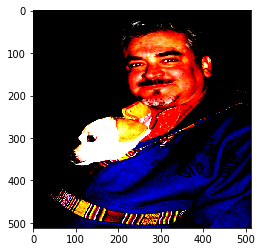

In [8]:
# show image
img = images.numpy()
plt.imshow(img.transpose(1,2,0))

In [9]:
# show targets
target = np.asarray(targets)
print(target)
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4]]).T
center

[[ 0.13314448  0.478       0.54957507  0.74       11.        ]
 [ 0.01983003  0.022       0.99433428  0.994      14.        ]]


array([[ 0.34135977,  0.609     , 11.        ],
       [ 0.50708215,  0.508     , 14.        ]])

In [10]:
img -= np.min(img)

plot center points


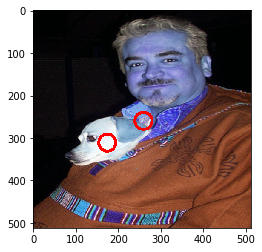

In [11]:
# Let's see if the center is encoded right

img2 = cv2.imread("../VOCdevkit/VOC2007/JPEGImages/000001.jpg")
img2 = cv2.resize(img2, (input_size, input_size))

# plot stuff centers
for c in center:
    img2 = cv2.circle(img2, (int(c[0]*input_size), int(c[1]*input_size)), 20, (255, 0, 0), 5)

print("plot center points")
plt.imshow(img2/255)
plt.show()
plt.imsave("imgs/center", img2/255)

The center is encoded right!

Now, we make the heatmaps so that centernet can train to predict centers.

In [12]:
# from centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
  tmp_size = sigma * 6
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap

def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

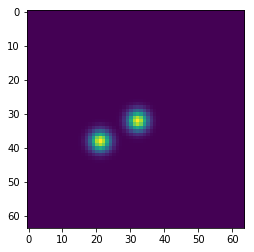

In [13]:
# make output heatmap for single class
hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE])

# show targets
target = np.asarray(targets)
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                     np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4]]).T

# make a center point
# try gaussian points.
for c in center:
    #hm[int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE] = 1
    hm = draw_msra_gaussian(hm, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
    
# plot and confirm if its working
plt.imshow(hm)
plt.show()

### make output heatmap for each class

heatmap of person class


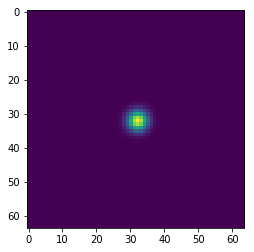

In [14]:
hm = np.zeros([num_class, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

# show targets
target = np.asarray(targets)
# convert targets to its center.
center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                     np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4].astype(int)]).T

# make a center point
# try gaussian points.
for c in center:
    mask = hm[int(c[2]), :, :]
    mask = draw_msra_gaussian(mask, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
    hm[int(c[2]), :, :] = mask
    
# plot and confirm if its working
print("heatmap of person class")
plt.imshow(hm[14])
plt.show()

### make regression targets.

[[ 0.13314448  0.478       0.54957507  0.74       11.        ]
 [ 0.01983003  0.022       0.99433428  0.994      14.        ]]
show regr


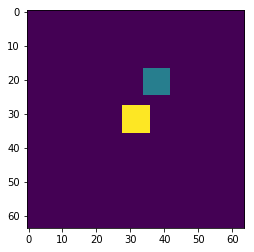

In [15]:
# [width_size, height_size]

# make regr heatmap 
regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

# show targets
target = np.asarray(targets)
print(target)
# convert targets to its center.
regrs = np.asarray([np.asarray([target[:,2]-target[:,0]]), \
                     np.asarray([target[:,3]-target[:,1]])]).T

# plot regr values to mask
for r, c in zip(regrs, center):
    y, x = int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE
    for i in range(-4, 4):
        for j in range(-4, 4):
            regr[:, int(c[0]*input_size)//MODEL_SCALE+i, int(c[1]*input_size)//MODEL_SCALE+j] = r
    #regr = draw_dense_reg(regr, center, [y,x], regrs, 0, False)

print("show regr")
plt.imshow(regr[0])
plt.show()

In [16]:
regr.shape

(2, 64, 64)

In [24]:
# wrap as function
def make_hm(target, input_size=512, num_class=20):
    # make output heatmap for each class
    hm = np.zeros([num_class, input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    # make regr heatmap 
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

    # convert targets to its center.
    center = np.asarray([np.mean(np.asarray([target[:,2],target[:,0]]), axis=0).T, \
                         np.mean(np.asarray([target[:,3],target[:,1]]), axis=0).T, target[:,4].astype(int)]).T
    regrs = np.asarray([np.asarray([target[:,2]-target[:,0]]), \
                     np.asarray([target[:,3]-target[:,1]])]).T

    # make masks
    for r, c in zip(regrs, center):
        mask = hm[int(c[2]), :, :]
        mask = draw_msra_gaussian(mask, [int(c[0]*input_size)//MODEL_SCALE, int(c[1]*input_size)//MODEL_SCALE])
        hm[int(c[2]), :, :] = mask
        for i in range(-3, 4):
            for j in range(-3, 4):
                xx = np.clip(int(c[0]*input_size)//MODEL_SCALE+i, 0, input_size//MODEL_SCALE-1)
                yy = np.clip(int(c[1]*input_size)//MODEL_SCALE+j, 0, input_size//MODEL_SCALE-1)
                regr[:, yy, xx] = r
    return hm, regr

# define dataloaders

In [25]:
class centerVOCDataset(data.Dataset):
    def __init__(self, img_list, anno_list, phase, transform, transform_anno, input_size=512):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
        self.input_size = input_size
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        im, hm, regr = self.pull_item(index)
        #print(im.shape)
        #print(hm.shape)
        #print(regr.shape)
        return im, hm, regr
    
    def pull_item(self, index):
        # 1. read image
        img_path = self.img_list[index]
        img = cv2.imread(img_path)
        height, width, channel = img.shape
        
        # 2. read annotations
        xml_path = self.anno_list[index]
        anno_list = self.transform_anno(xml_path, width, height)
        
        # 3. augumentations
        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4])
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        
        # 4. transform BGR to RGB
        img = torch.from_numpy(img[:, :, (2, 1, 0)])
        img = img.permute(2, 0, 1)
        
        # 5. convert boxes inforatmion to heatmaps
        hm, regr = make_hm(gt, self.input_size)
        
        return img, hm, regr

In [26]:
# test dataloader
# call dataset
train_dataset2 = centerVOCDataset(train_img_list, train_anno_list, phase = "train", transform=transform, transform_anno = transform_anno, input_size=input_size)
val_dataset2 = centerVOCDataset(val_img_list, val_anno_list, phase="val", transform=DatasetTransform(
    input_size), transform_anno=Anno_xml2list(voc_classes), input_size=input_size)

# dataloader
train_dataloader = data.DataLoader(
    train_dataset2, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader = data.DataLoader(
    val_dataset2, batch_size=batch_size, shuffle=False, num_workers=8)
# as dict
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


im


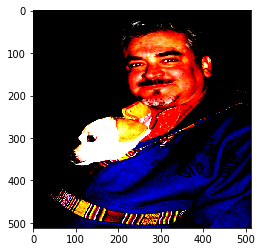

heatmap


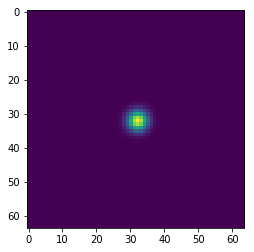

regr


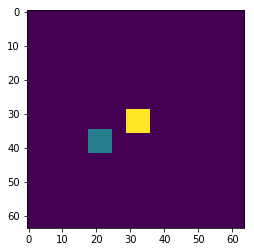

In [32]:
# confirm operation
im, hm, regr = val_dataset2[0]
print("im")
plt.imshow(im.numpy().transpose(1,2,0))
plt.show()
print("heatmap")
plt.imshow(hm[14])
plt.show()
print("regr")
plt.imshow(regr[0])
plt.show()

In [33]:
im.shape

torch.Size([3, 512, 512])

In [34]:
np.concatenate([hm,regr]).shape

(22, 64, 64)

# define Centernet model and test

In [35]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

# create backbone.
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[:-2])

In [37]:
class centernet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(centernet, self).__init__()
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue
        self.outr = nn.Conv2d(256, 2, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.base_model(x)
        
        # Add positional info        
        x = self.up1(x)
        x = self.up2(x)
        #x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

In [38]:
# test if net works
model = centernet(num_class) # +2 for width and height regressions
print(torch.rand([1,3,input_size,input_size]).size())
outc, outr = model(torch.rand([1,3,input_size,input_size]))
print(outc.size())
print(outr.size())

torch.Size([1, 3, 512, 512])
torch.Size([1, 20, 64, 64])
torch.Size([1, 2, 64, 64])


# set up optimizers

In [39]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## setup focal loss

In [40]:
# focal loss
def neg_loss(pred, gt):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
  '''
  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 2) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 2) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos
  return loss

def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  #print(gt_regr.size())
  mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
  #print(mask.size())

  regr = regr * mask
  gt_regr = gt_regr * mask
    
  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss

def criterion(pred_mask, pred_regr, mask, regr, weight=0.4, size_average=True, num_class=20):
    # Binary mask loss
    pred_mask = torch.sigmoid(pred_mask) # class masks
    mask_loss = neg_loss(pred_mask, mask)
    
    sum=np.sum(mask.cpu().numpy()==1)
    
    # Regression L1 loss
    #print(pred_regr.size())
    #print(regr.size())
    regr_loss = _reg_loss(pred_regr, regr, mask)
    #regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask.sum(1)).sum(1).sum(1) / mask.sum(1).sum(1).sum(1)
    #regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = mask_loss +regr_loss * 10
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [41]:
# while the original efficientdet uses cosine annealining lr scheduling, we utilize epoch-based lr decreasing for simplicity.
def get_current_lr(epoch): 
    reduce = [80,120]
    lr = 1e-3
        
    for i,lr_decay_epoch in enumerate(reduce):
        if epoch >= lr_decay_epoch:
            lr *= 0.1
    return lr

def adjust_learning_rate(optimizer, epoch):
    lr = get_current_lr(epoch)
    print("lr is:", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [42]:
# pool duplicates
def pool(data):
    stride = 3
    for y in np.arange(1,data.shape[1]-1, stride):
        for x in np.arange(1, data.shape[0]-1, stride):
            a_2d = data[x-1:x+2, y-1:y+2]
            max = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))
            
            for c1 in range(3):
                for c2 in range(3):
                    #print(c1,c2)
                    if not (c1== max[0] and c2 == max[1]):
                        data[x+c1-1, y+c2-1] = -1
    return data

# set up train and eval scripts

In [43]:
# train script. nothing special..
import gc
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("used device:", device)

    # ネットワークをGPUへ
    model.to(device)
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):
        
        adjust_learning_rate(optimizer, epoch)
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに
                print('(train)')
            else:
                if((epoch+1) % 2 == 0):
                    model.eval()   # モデルを検証モードに
                    print('-------------')
                    print('(val)')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, hm, regr in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                hm = hm.to(device)
                regr = regr.to(device)
                
                if HALF:
                    images = images.half()
                    targets = [ann.half() for ann in targets]
                    
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    mask, mask_regr = model(images)
                    #print(outputs[0].type())
                    # 損失の計算
                    loss, mask_loss, regr_loss = criterion(mask, mask_regr, hm, regr)

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            model.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('Iter {} || Loss: {:.4f} || Mask: {:.4f} || Regr: {:.4f}'.format(
                                iteration, loss.item(), mask_loss.item(), regr_loss.item()))
                            t_iter_start = time.time()
                        # filter inf..
                        if not loss.item() == float("inf"):
                            epoch_train_loss += loss.item()
                        iteration += 1
                        
                        if iteration%100 == 0:
                            id = 0
                            img, hm, regr = val_dataset2[id]
                            img = img.to(device).unsqueeze(0)
                            with torch.no_grad():
                                hm, regr = model(img)
                            hm = hm.cpu().numpy();regr = regr.cpu().numpy()
                            plt.imshow(hm[0,14])
                            plt.show()
                            plt.imshow(hm[0,14]>0)
                            plt.show()
                            plt.imshow(regr[0,0])
                            plt.show()

                    # 検証時
                    else:
                        if not loss.item() == float("inf"):
                            epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log/"+DATASET+"_"+model_name+"_" + str(input_size) +"log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和
        gc.collect()

        # ネットワークを保存する
        if((epoch+1) % 10 == 0):
            torch.save(model.state_dict(), 'weights/'+DATASET+"_"+model_name+"_" + str(input_size) + "_" + 
                       str(epoch+1) + '.pth')


In [ ]:
num_epochs = 150
torch.cuda.empty_cache()
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

used device: cuda:0
lr is: 0.001
-------------
Epoch 1/150
-------------
(train)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
